## Setup - Access SPD Crime Data via API

In [137]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

app_token = os.environ.get('CITY_OF_SEATTLE_APP_TOKEN')
username = os.environ.get('CITY_OF_SEATTLE_USERNAME')
password = os.environ.get('CITY_OF_SEATTLE_PASSWORD')

# Sample code taken from API documentation
#Example authenticated client (needed for non-public datasets):
client = Socrata("data.seattle.gov",
                 app_token,
                 username=username,
                 password=password)

# First 20000000 results, returned as JSON from API
results = client.get("tazs-3rd5", limit=2000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

## Question 1 - Summary table of 2024 offenses by Crime Against Category and Precinct

In [138]:
# create year column to filter on, choosing to interpret offense date as "start date"
results_df['offense_date'] = pd.to_datetime(results_df['offense_date'])
results_df['offense_year'] = results_df['offense_date'].dt.year

# rename columns for readability
results_df = results_df.rename(columns={'offense_year':'Offense Year','precinct':'Precinct','nibrs_crime_against_category':'Crime Against Category'})

# 2024 dataframe
crime_data_2024_df = results_df.loc[results_df['Offense Year'] == 2024,]

# filter out non-standard precincts
standard_precinct_list = ['East','North','South','Southwest','West']
crime_data_2024_df = crime_data_2024_df.loc[crime_data_2024_df['Precinct'].isin(standard_precinct_list),]

# summarize the data by category and precinct
crime_data_2024_summary = crime_data_2024_df.groupby(['Precinct','Crime Against Category']).size()


In [139]:
# create and display summary table
crime_data_2024_summary_table = crime_data_2024_summary.reset_index().rename(columns={0:'Crime Count'})
display(crime_data_2024_summary_table.style.hide())

Precinct,Crime Against Category,Crime Count
East,ANY,496
East,NOT_A_CRIME,1501
East,PERSON,2228
East,PROPERTY,9384
East,SOCIETY,1028
North,ANY,673
North,NOT_A_CRIME,1873
North,PERSON,3452
North,PROPERTY,18419
North,SOCIETY,1050


### The chart above shows the total count of crimes in the SPD database for 2024 broken down by Precinct and Crime Against Category. A quick inspection of these totals shows that property crimes are the most common in all precincts.

## Question 2 - Charts of crime totals by Crime Against Category and Precinct between 2019 and 2024

In [ ]:
# 2019-2024 dataframe
crime_data_2019_2024_df = results_df.loc[(results_df['Offense Year'] >= 2019) & (results_df['Offense Year'] <= 2024),]

# filter out non-standard precincts
standard_precinct_list = ['East','North','South','Southwest','West']
crime_data_2019_2024_df = crime_data_2019_2024_df.loc[crime_data_2019_2024_df['Precinct'].isin(standard_precinct_list),]

# summarize the data by category and precinct
crime_data_2019_2024_summary = crime_data_2019_2024_df.groupby(['Offense Year','Precinct','Crime Against Category']).size()

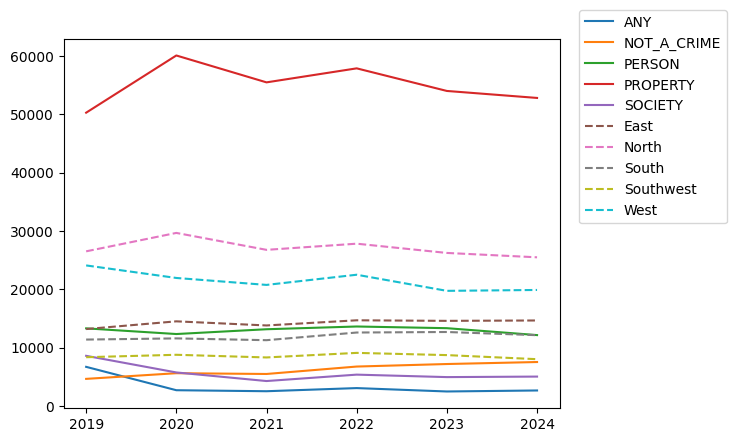

In [141]:
# summarize the data by category and precinct
crime_data_2019_2024_summary_category = crime_data_2019_2024_df.groupby(['Offense Year','Crime Against Category']).size().unstack()
crime_data_2019_2024_summary_precinct = crime_data_2019_2024_df.groupby(['Offense Year','Precinct']).size().unstack()


# create combined chart
plt.plot(crime_data_2019_2024_summary_category, label=crime_data_2019_2024_summary_category.columns)
plt.plot(crime_data_2019_2024_summary_precinct, label=crime_data_2019_2024_summary_precinct.columns, linestyle='--')
plt.gca().legend(loc=(1.04, 0.5))
plt.show()

### The chart above plots both the Crime Against Category and Precinct totals by year from 2019 through 2024. The solid lines represent the Crime Against Category totals and the dashed lines represent the Precinct totals. My main takeaway from this chart is that by far the most common type of crime over this period is property crime. There is also a notable spike in these property crimes in 2020. However, plotting these two separate categories of crime against and precinct in one chart makes it a bit harder to interpret the minor shifts occurring over this time period. I found it easier to break this data into two charts that can be interpreted separately, as shown below.

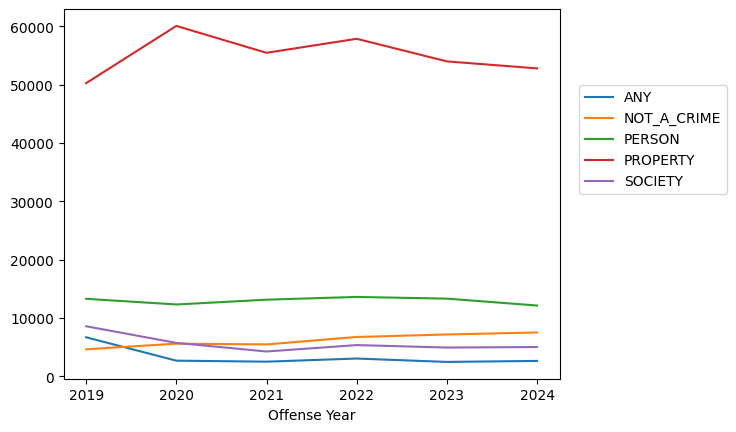

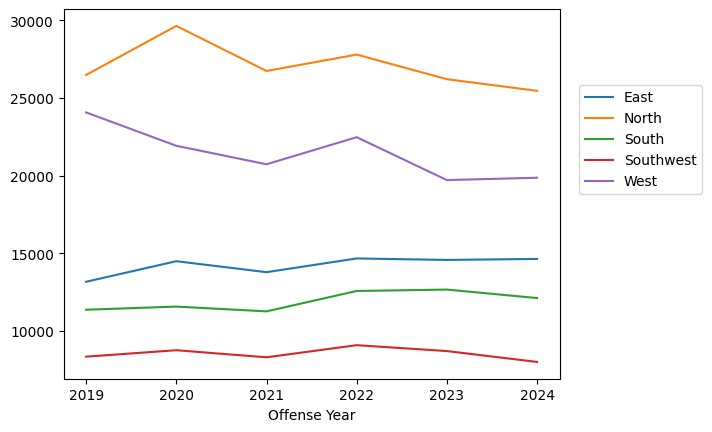

In [142]:
# create separate charts for easier interpretability
crime_data_2019_2024_summary_category.plot(kind='line')
plt.gca().legend(loc=(1.04, 0.5))
crime_data_2019_2024_summary_precinct.plot(kind='line')
plt.gca().legend(loc=(1.04, 0.5))
plt.show()

### The separate crime against chart does not have many additional easy-to-spot trends; the non-property crimes remained relatively steady over this period. However, having a separate precinct chart does illustrate some more pronounced spikes in 2020 for the North precinct and an overall downward slope for the West precinct over the period of 2019-2024. The East, South, and Southwest precincts saw relatively stable crime totals over 2019-2024.

## Question 3 - Spatial breakdown of property crimes by Seattle Council District

### The number of property crime offenses committed in each council district can be determined by linking each crime in the 2024 dataset to a specific geographic area, which can then be mapped to the shapefile provided. In looking through the columns of the crime dataset, potential geographic columns include Block Address, Latitude, Longitude, Beat, Precinct, Sector, Neighborhood, and Reporting Area. Unfortunately, it looks like the most useful columns for mapping these locations to a shapefile (Latitude and Longitude) are not populated in this dataset. So the next option would be to find a crime dataset that does have lat/long coordinates available for property crimes which can then be mapped directly on to the council district shapefile. Another option would be to find shapefiles for some of the other geographic columns like Beat, Precinct, Sector, or Neighborhood and join those other shapefiles to the council district shapefile and the crime dataset. In searching around the Seattle GIS portal link provided, it does look like the police beats are also mapped and available here (http://data-seattlecitygis.opendata.arcgis.com/datasets/SeattleCityGIS::seattle-police-department-beats-web-mercator/about). With the right tools, it should be relatively straight-forward to join the district and beat maps and then join the crime data to that combined map to determine the property crime totals by district.